# Variational Autoencoder in TensorFlow

From Jan Hendrik Metzen 2017-01-03 
with a small mods by d. gannon

From Metzen's intro:

The main motivation for this post was that I wanted to get more experience with both [Variational Autoencoders](http://arxiv.org/abs/1312.6114) (VAEs) and with [Tensorflow](http://www.tensorflow.org/). Thus, implementing the former in the latter sounded like a good idea for learning about both at the same time. This post summarizes the result.

Note: The post was updated on December 7th 2015:
  * a bug in the computation of the latent_loss was fixed (removed an erroneous factor 2). Thanks Colin Fang for pointing this out.
  * Using a Bernoulli distribution rather than a Gaussian distribution in the generator network

Note: The post was updated on January 3rd 2017:
  * changes required for supporting TensorFlow v0.12 and Python 3 support

Notes on this version
----------
From d. gannon:
This version uses images courtesy of Maryana Alegro from the University of California, San Francisco.  It is really interesting.   Dr. Alegro tells us that the data consists of “images of neurons drawn from real immunofluorescence (IF) microscopy of post-mortem human brain tissue. These are part of an UCSF study that aims to understand Alzheimer’s disease (AD) development in brain stem nuclei, which are affected by the disease years before initial symptoms onset. The red cells are stained using a fluorescence marker called CP-13 that binds to TAU tangles, commonly associated with AD. Green cells are stained for aCasp-6, which binds to proteins present during apoptosis (cell death) and yellow cells that have overlap of both markers.”  The goal for their project is to was quantifying the presence of these three classes in IF images can help understand if the presence of TAU is really causing cell death in brain stem nuclei.   They have a very nice paper “Automating cell detection and classification in human brain fluorescent microscopy images using dictionary learning and sparse coding” in Journal of Neuroscience Methods 282 (2017) 20–33, that describes some of their work.

The article that describes the work here is https://cloud4scieng.org/manifold-learning-and-deep-autoencoders-in-science/


In [2]:
import numpy as np
import tensorflow as tf
import cv2
import random

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)
totalimg = 1032
n_samples = totalimg

## download the data
The link to download a tar'd gzipped copy of the data is here: http://www.imagexd.org/assets/cells.tar.gz .   The following function is looking for the path to the un-tar'd images and a file with the name of each image one per line.  you can create this file with the command

ls  > classlist

In [3]:
def read_images(size, listfile, datafile):
    classes = np.array([0]*size)
    data = np.array([np.zeros(28*28*3, dtype=np.float32)]*size )
    #print data.shape
    with open(listfile) as f:
        i = 0
        for line_of_text in f:
            if i == size:
                return classes, data
            with open(datafile+"/"+line_of_text[:-1], 'rb') as infile:
                 buf = infile.read()
            infile.close()
            #use numpy to construct an array from the bytes
            x = np.fromstring(buf, dtype='uint8')
            #decode the array into an image
            img = cv2.imdecode(x, cv2.IMREAD_UNCHANGED)
            img2 = cv2.resize(img, (28,28))
            img3 = img2.reshape(28*28*3)
            f = 256.0
            data[i] = img3/(1.0*f)
            x = line_of_text.find("class")
            classes[i] = int(line_of_text[x+5:x+6])
            i = i+1
    if i != size:
        print("size error "+i)
    return classes, data

I have stored the untar'd and ungzipped data in director newcells/cells.
In addition to reading the full dataset, save all the class0, class1 and class0 cells in seperate directories.  We will use these later.

In [4]:
classes, data = read_images(totalimg, 'newcells/cells/classlist', 'newcells/cells')
c2class,c2data = read_images(300,'newcells/class2/classlist','newcells/class2')
c1class,c1data = read_images(300,'newcells/class1/classlist','newcells/class1')
c0class,c0data = read_images(310,'newcells/class0/classlist','newcells/class0')


In [5]:
c0data.shape

(310, 2352)

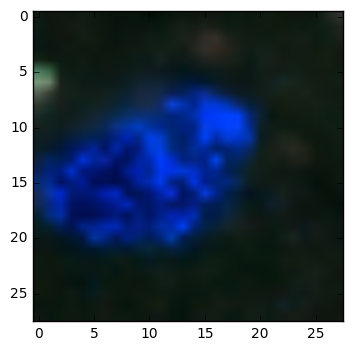

In [6]:
plt.imshow(c0data[305].reshape(28, 28,3))

In [7]:
def get_next_batch(size, classes, data):
    if size > totalimg:
        s = totalimg
    else:
        s = size
    c = np.array([0]*s)
    d = np.array([np.zeros(28*28*3, dtype=np.float32)]*s )
    for i in range(s):
        j = np.random.randint(0,len(classes)-1)
        c[i]= classes[j]
        d[i]= data[j]
    return d, c

    

In [8]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

Based on this, we define now a class "VariationalAutoencoder" with a [sklearn](http://scikit-learn.org)-like interface that can be trained incrementally with mini-batches using partial_fit. The trained model can be used to reconstruct unseen input, to generate new samples, and to map inputs to the latent space.

$$ KL(P || Q) = - \sum_x p(x)log q(x) + \sum_x p(x)log(p(x)) $$


$$ Z_{\mu} , Z_{ln(\sigma^2)} = enc(X) $$
$$ \epsilon \in N(0,1) $$
$$  Z  = Z_{\mu} + \epsilon \sqrt{exp(Z_{ln(\sigma^2)})} $$
$$  X_{recon\mu} =  dec(Z) $$

the loss function is 

$$ ReconLoss = \sum{ (X*ln(X_{recon\mu}) + (1-X)*ln(1 - X_{recon\mu})})$$
$$ LatentLoss = \sum{ (1+Z_{ln(\sigma^2)} - {Z_{\mu}}^2 - \exp(Z_{ln(\sigma^2)})) } $$
                                          

In [9]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In general, implementing a VAE in tensorflow is relatively straightforward (in particular since we don not need to code the gradient computation). A bit confusing is potentially that all the logic happens at initialization of the class (where the graph is generated), while the actual sklearn interface methods are very simple one-liners.

We can now define a simple fuction which trains the VAE using mini-batches:

In [10]:
def train(network_architecture, learning_rate=0.0001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = get_next_batch(batch_size, classes, data)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Illustrating reconstruction quality

We can now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [11]:
network_architecture = \
    dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
         n_hidden_recog_2=1000, # 2nd layer encoder neurons
         n_hidden_gener_1=1000, # 1st layer decoder neurons
         n_hidden_gener_2=1000, # 2nd layer decoder neurons
         n_input=28*28*3, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=2500)

('Epoch:', '0001', 'cost=', '1503.554197799')
('Epoch:', '0006', 'cost=', '1175.129356680')
('Epoch:', '0011', 'cost=', '1142.124820680')
('Epoch:', '0016', 'cost=', '1117.732226941')
('Epoch:', '0021', 'cost=', '1123.777427969')
('Epoch:', '0026', 'cost=', '1102.219869924')
('Epoch:', '0031', 'cost=', '1109.888665251')
('Epoch:', '0036', 'cost=', '1120.647270735')
('Epoch:', '0041', 'cost=', '1117.311640303')
('Epoch:', '0046', 'cost=', '1099.075967951')
('Epoch:', '0051', 'cost=', '1098.661792371')
('Epoch:', '0056', 'cost=', '1112.151922182')
('Epoch:', '0061', 'cost=', '1113.598088701')
('Epoch:', '0066', 'cost=', '1115.497500397')
('Epoch:', '0071', 'cost=', '1100.419486586')
('Epoch:', '0076', 'cost=', '1090.798157685')
('Epoch:', '0081', 'cost=', '1096.583320559')
('Epoch:', '0086', 'cost=', '1084.205154301')
('Epoch:', '0091', 'cost=', '1088.264063162')
('Epoch:', '0096', 'cost=', '1085.455263123')
('Epoch:', '0101', 'cost=', '1106.583303999')
('Epoch:', '0106', 'cost=', '1079.

Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

let's grab some of the class0 images and show them alongside their reconstruction

In [12]:
x_sample =get_next_batch(100, c0class, c0data)[0]
x_reconstruct = vae.reconstruct(x_sample)

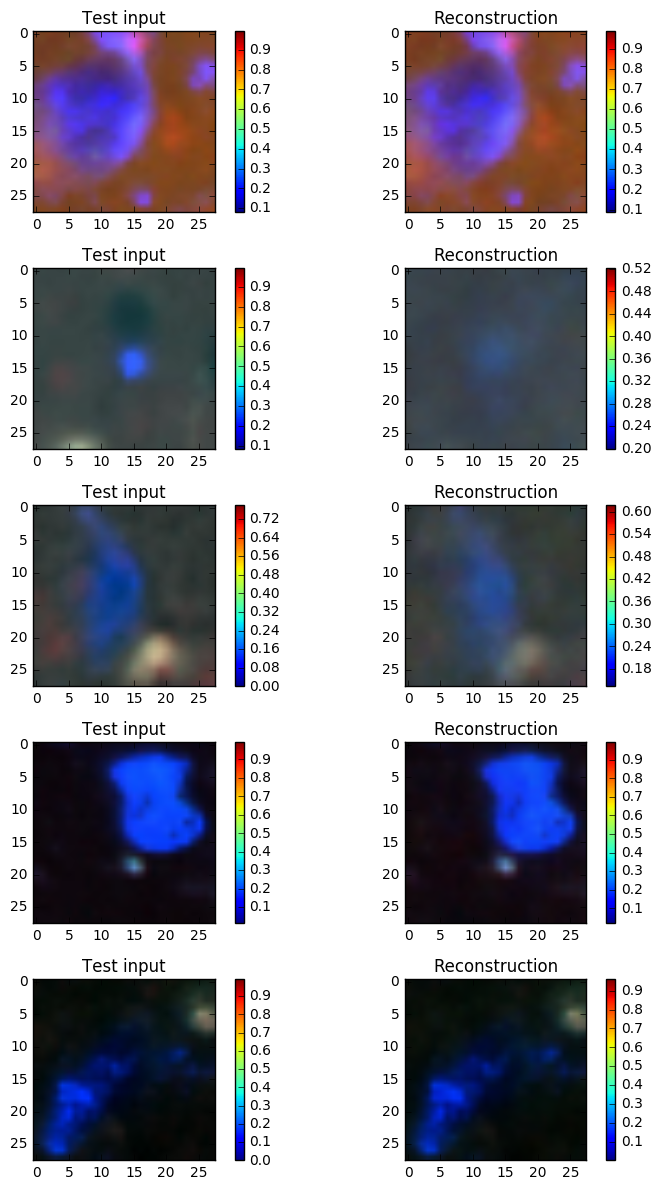

In [17]:

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i+20].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i+20].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

now show a class1 example.

In [18]:
c1_recon = vae.reconstruct(c1data[:100])

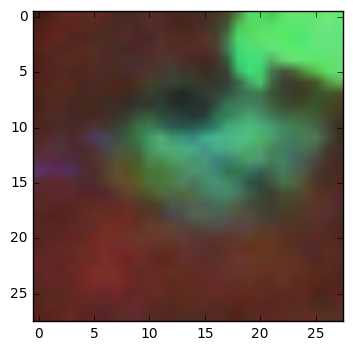

In [22]:
plt.imshow(c1_recon[10].reshape(28, 28,3))

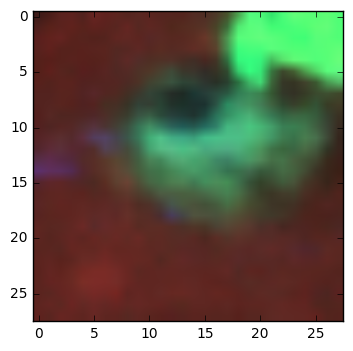

In [21]:
plt.imshow(c1data[10].reshape(28, 28,3))

In [23]:
import imageio
import pickle


Next let's save 100 reconstructions for each class for testing with scikit lean.

In [24]:
v2 = get_next_batch(100, c2class, c2data)[0]
c2_recon = vae.reconstruct(v2)
with open('newcells/class2/recon.pickle', 'wb') as f:
    var = {'class' : c2class[:100] , 'data' : c2_recon}
    pickle.dump(var, f)

In [25]:
v1 = get_next_batch(100, c1class, c1data)[0]
c1_recon = vae.reconstruct(v1)
with open('newcells/class1/recon.pickle', 'wb') as f:
    var = {'class' : c1class[:100] , 'data' : c1_recon}
    pickle.dump(var, f)

In [26]:
v0 = get_next_batch(100, c0class, c0data)[0]
c0_recon = vae.reconstruct(v0)
with open('newcells/class0/recon.pickle', 'wb') as f:
    var = {'class' : c0class[:100] , 'data' : c0_recon}
    pickle.dump(var, f)

In [27]:
#the following is a sanity check

In [28]:
with open('newcells/class0/real.pickle', 'wb') as f:
    var = {'class' : c0class[:100] , 'data' : v1}
    pickle.dump(var, f)

In [ ]:
#lets look at the  class 0 images
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(v0[i+10].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(c0_recon[i+10].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [29]:
from IPython.display import Image
from IPython.display import display


In [30]:
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel


In [31]:
RS = 20150101

In [32]:
x_sample, y_sample = get_next_batch(1000, classes, data)
z = vae.transform(x_sample)

In [33]:
z.shape

(1000, 20)

Now we will look at the t-sne projection of these 1000 images

In [34]:
digits_proj = TSNE(random_state=RS).fit_transform(z)
#digits_proj = TSNE(random_state=RS).fit_transform(x_sample)

In [35]:
digits_proj.shape

(1000, 2)

In [36]:
norm(z[1])

2.7719715

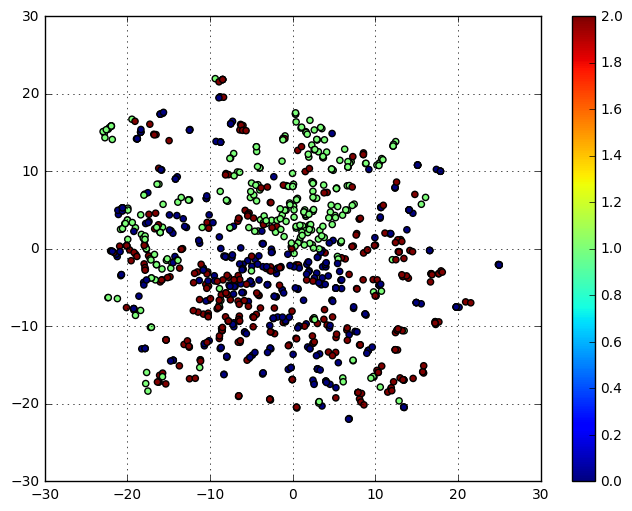

In [37]:
plt.figure(figsize=(8, 6)) 
plt.scatter(digits_proj[:, 0], digits_proj[:, 1], c=y_sample)
plt.colorbar()
plt.grid()

now the t-sne projection of the original data

In [38]:
#digits_proj = TSNE(random_state=RS).fit_transform(z)
digits_proj2 = TSNE(random_state=RS).fit_transform(x_sample)


In [39]:
digits_proj2.shape

(1000, 2)

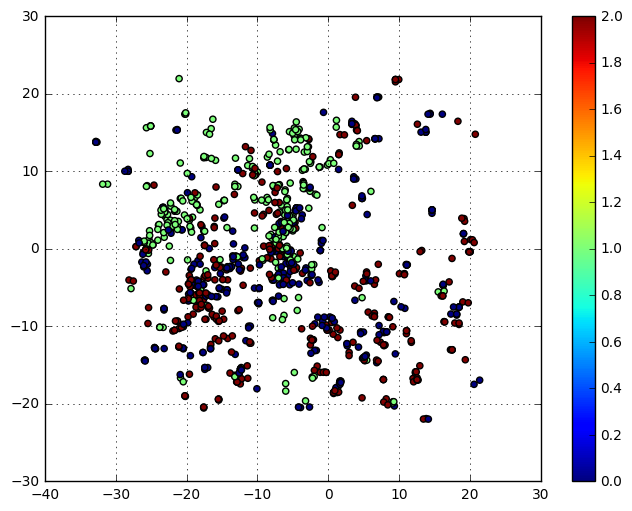

In [40]:
plt.figure(figsize=(8, 6)) 
plt.scatter(digits_proj2[:, 0], digits_proj[:, 1], c=y_sample)
plt.colorbar()
plt.grid()

In [41]:
zz = [norm(z[i]) for i in range(1000)]

let's look at the distribution of the norms of the recon images

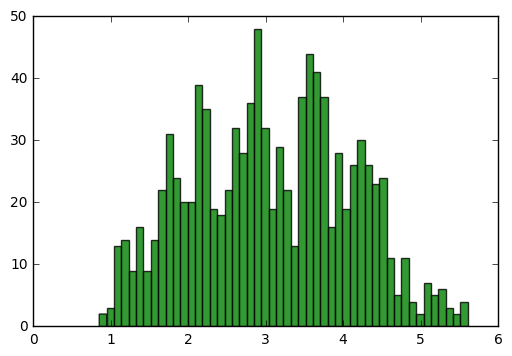

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
numBins = 50
ax.hist(zz,numBins,color='green',alpha=0.8)
plt.show()

What is interesting here is that the norms are mostly greater than one.  This implies that the cluster of points near origin in the t-sne image of the z space is a false impression.  This suggests our manifold is more like a sphere in z-space.   no matter how you flatten a sphere onto 2D it would  show points near the origin.


## a movie through the latent manifold
we will  pick a path through the latent space using six start and stop points and lineraly interpreting the path between.  we generate the corresponding images.  the start and stop points correspond to spots in the image of the transformed sample z.

NOTE: this following steps were done with a previous execution of this notebook.  that makes it consistent with the movie in the blog.

In [61]:
v = get_next_batch(100, c2class, c2data)[0]
z = vae.transform(v)


In [66]:
start = [2,12,  25, 40, 50]
end =   [12, 25, 40,  50, 2]

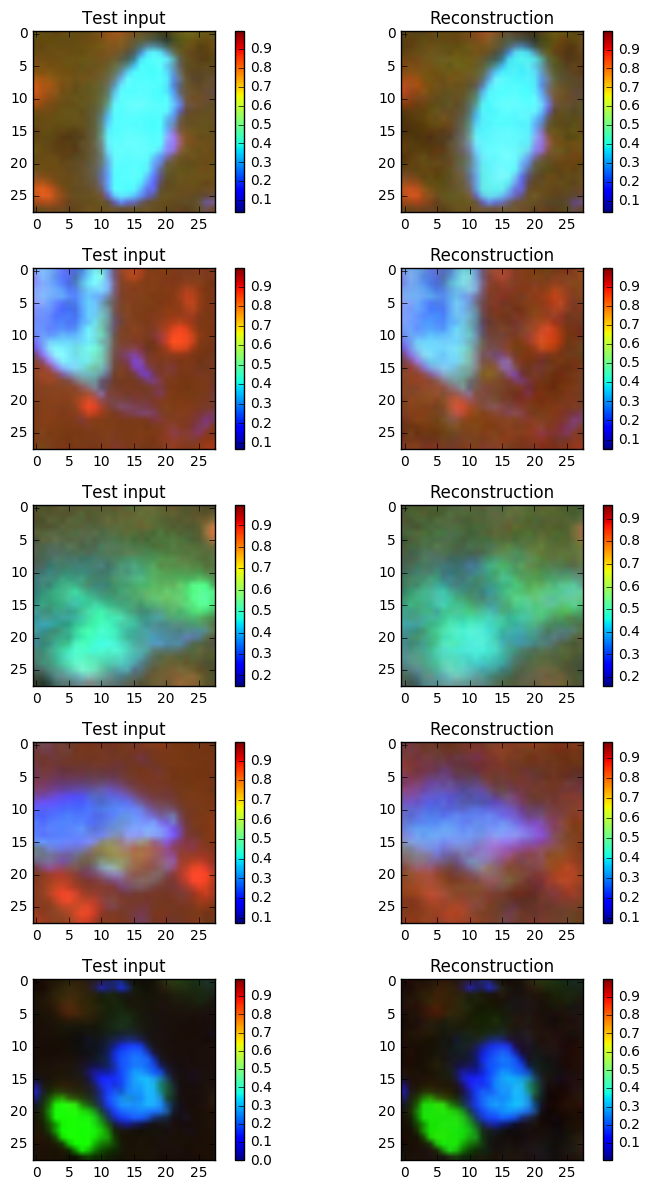

In [67]:
#lets look at the  class 0 images
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(v[start[i]].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    d = np.array([z[start[i]]]*100)
    plt.imshow(vae.generate(z_mu=d)[0].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [68]:
figlist = []
for seg in range(5):
    m = 100
    a = z[start[seg]]
    b = z[end[seg]]
    d = np.array([a]*m)
    for s in range(m):
        d[s]=(s/(m*1.0))*b+(1.0-(s/(m*1.0)))*a
    a_ar =vae.generate(z_mu=d)

    for i in range(m):
        filename = "pics/r-color"+str(seg*100+i)+".png"
        figlist.append(filename)
        im = plt.imsave(filename, a_ar[i].reshape(28, 28, 3))#, vmin=0, vmax=1, cmap="gray")
    
a_ar.shape

(100, 2352)

now cat the images together to make a movie. note: you need a different movie name each time you run this because it caches the old ones.  

In [71]:
images = []
for filename in figlist:
    #print filename
    images.append(imageio.imread(filename))
#imageio.mimsave('movie7.gif', images)

In [46]:
display(Image(url='movie7.gif', width=400, height=400))

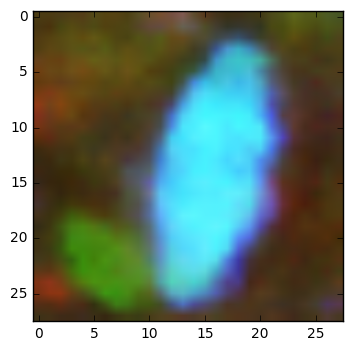

In [73]:
 plt.imshow(a_ar[70].reshape(28, 28,3))#, vmin=0, vmax=1, cmap="gray")

In [47]:
from sklearn import svm, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier: a support vector classifier
#classifier = svm.SVC(gamma=0.8)
#classifier = RandomForestClassifier(max_depth=10)
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=0)

In [48]:
test_classes = np.array([0]*200)
test_data = np.array([np.zeros(28*28*3, dtype=np.float32)]*200)
train_classes = np.array([0]*(totalimg-200))
train_data = np.array([np.zeros(28*28*3, dtype=np.float32)]*(totalimg-200) )


In [49]:
train_data.shape

(832, 2352)

In [55]:
indexes = set()
for i in range(totalimg):
    indexes.add(i)
repcount = 0
for i in range(totalimg-200):
    ok = False
    while(ok == False):
        j = np.random.randint(0,totalimg)
        if j in indexes:
            indexes.remove(j)
            ok = True
            train_classes[i] = classes[j]
            train_data[i] = data[j]
        else:
            repcount = repcount+1
print repcount

834


In [56]:
x = list(indexes)
for i in range(200):
    test_classes[i] = classes[x[i]]
    test_data[i]= data[x[i]]

In [57]:
train_classes

array([2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0,
       1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 2, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 0, 1, 2, 0,
       0, 1, 0, 2, 2, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 2,
       2, 2, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0,
       2, 1, 2, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1,
       0, 1, 0, 2, 0, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 0, 2, 0,
       0, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2,
       2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0,
       2, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2,
       1, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 2, 2, 0, 2, 0, 2, 0,
       1, 0,

In [58]:
classifier.fit(train_data, train_classes)

GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [59]:
expected = test_classes
predicted = classifier.predict(test_data)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False):
             precision    recall  f1-score   support

          0       0.87      0.95      0.91        77
          1       0.87      0.84      0.85        63
          2       0.76      0.70      0.73        60

avg / total       0.84      0.84      0.84       200


Confusion matrix:
[[73  0  4]
 [ 1 53  9]
 [10  8 42]]


Now let's unpickle our reconstructed data and see how the classifier ranks them


In [60]:
import pickle
def get_recon_batch(picklefile):
    with open(picklefile,'rb') as f:
        dic = pickle.load(f)
        data = dic['data']
        cl = dic['class']
        print("shape of pickle file ="+str(data.shape))
        #cl = np.array([np.zeros(3)]*data.shape[0])
        #l = data.shape[0]
        #cl[i] = l
    return data, cl   

In [61]:
reco2data, reco2class = get_recon_batch("newcells/class2/recon.pickle")
reco0data, reco0class = get_recon_batch("newcells/class0/recon.pickle")
reco1data, reco1class = get_recon_batch("newcells/class1/recon.pickle")

shape of pickle file =(100, 2352)
shape of pickle file =(100, 2352)
shape of pickle file =(100, 2352)


In [62]:
# first class 0
expected = reco0class
predicted = classifier.predict(reco0data)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False):
             precision    recall  f1-score   support

          0       1.00      0.87      0.93       100
          1       0.00      0.00      0.00         0
          2       0.00      0.00      0.00         0

avg / total       1.00      0.87      0.93       100


Confusion matrix:
[[87  9  4]
 [ 0  0  0]
 [ 0  0  0]]


/usr/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [63]:
# next class 1
expected = reco1class
predicted = classifier.predict(reco1data)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.93      0.96       100
          2       0.00      0.00      0.00         0

avg / total       1.00      0.93      0.96       100


Confusion matrix:
[[ 0  0  0]
 [ 5 93  2]
 [ 0  0  0]]


In [64]:
# next class 2s
expected = reco2class
predicted = classifier.predict(reco2data)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier GradientBoostingClassifier(init=None, learning_rate=1.0, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         0
          2       1.00      0.72      0.84       100

avg / total       1.00      0.72      0.84       100


Confusion matrix:
[[ 0  0  0]
 [ 0  0  0]
 [15 13 72]]
